In [1]:
import os
import time
import json
import numpy as np
import matplotlib.pyplot as plt
import torch
import random
from utils.graph_env import set_objects
set_objects('set1')

from utils.graph_env import (
    OBJECTS,
    create_graph, plot_graph, cal_density, get_obj_sizes,
    Indices, get_obj_label, get_obj_pos, get_obj_size,
    find_target_obj,
)

Using default object sizes


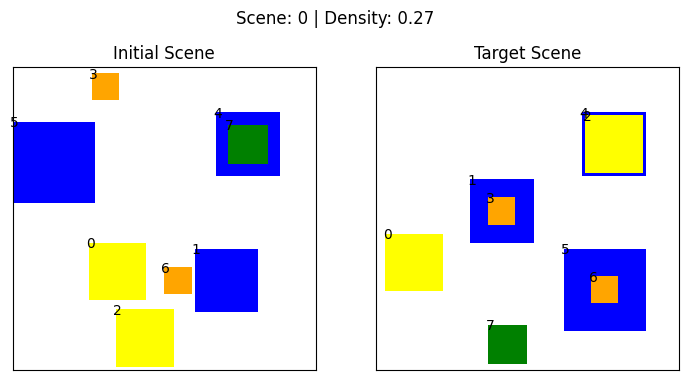

Saved scene to example_scenes/scene_0.json


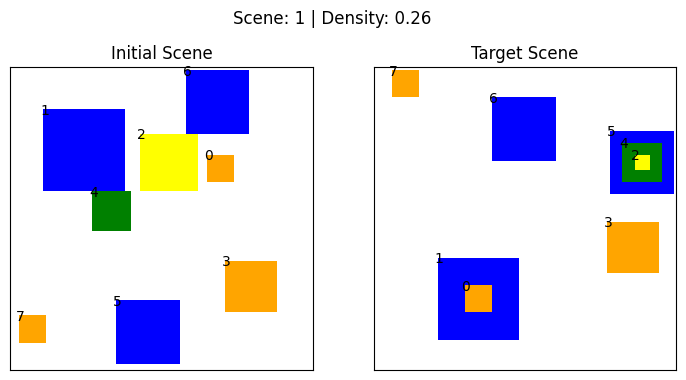

Saved scene to example_scenes/scene_1.json


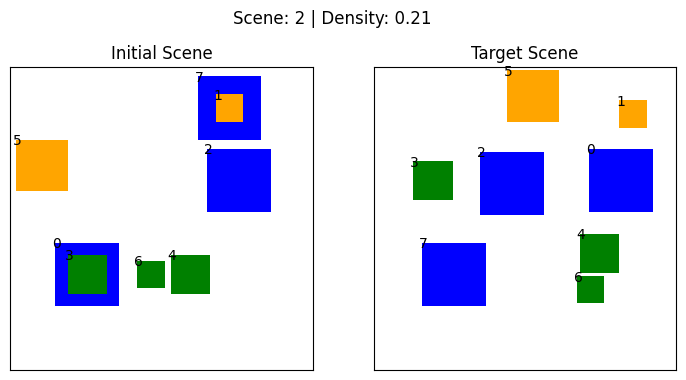

Saved scene to example_scenes/scene_2.json


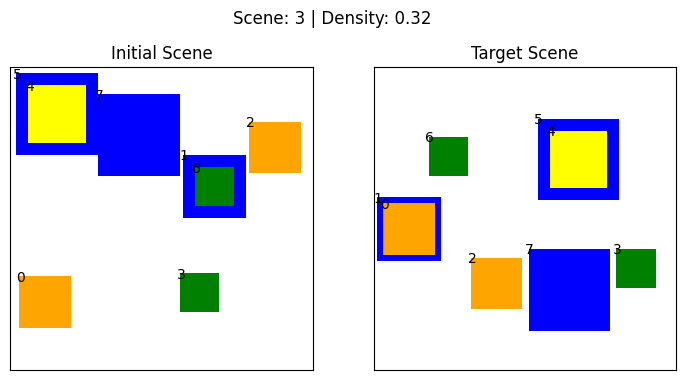

Saved scene to example_scenes/scene_3.json


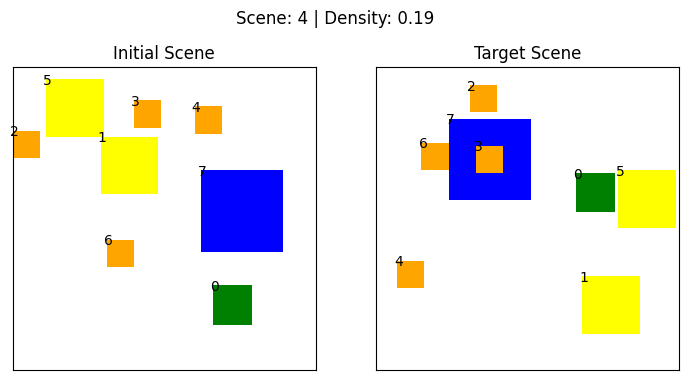

Saved scene to example_scenes/scene_4.json


In [2]:
def save_scene_json(dir_path, grid_size, initial_scene, target_scene, scene_id):
	os.makedirs(dir_path, exist_ok=True)

	num_objects = initial_scene.num_nodes
	
	# save the scene in a json file
	objs = []
	for obj in range(num_objects):
		objs.append({
			'object_id': obj,
			'label': get_obj_label(initial_scene.x, obj),
			'size': get_obj_size(initial_scene.x, obj),
			'initial_pos': get_obj_pos(initial_scene.x, obj).tolist(),
			'initial_base_id': find_target_obj(initial_scene.x, obj),
			'target_pos': get_obj_pos(target_scene.x, obj).tolist(),
			'target_base_id': find_target_obj(target_scene.x, obj), 
		})
	
	json_scene = {
		'scene_id': scene_id,
		'phi': cal_density(initial_scene, grid_size),
		'num_objects': num_objects,
		'grid_size': grid_size,
		'objects': objs
	}
	
	# Save the scene in a json file
	with open(f'{dir_path}/scene_{scene_id}.json', 'w') as f:
		json.dump(json_scene, f, indent=4)

	print(f'Saved scene to {dir_path}/scene_{scene_id}.json')

def create_initial_target_scenes(num_objects, grid_size, object_sizes, stack_prob):
	initial_graph = create_graph(num_objects, grid_size, len(object_sizes), object_sizes, None, stack_prob=stack_prob)

	labels = list(initial_graph.x[:, Indices.LABEL].reshape(-1).numpy())
	labels = list(map(int, labels))
	target_graph = create_graph(num_objects, grid_size, len(object_sizes), object_sizes, labels, stack_prob=stack_prob)
	while torch.equal(initial_graph.x, target_graph.x):
		target_graph = create_graph(num_objects, grid_size, len(object_sizes), object_sizes, labels, stack_prob=stack_prob)

	return initial_graph, target_graph

phi = 'mix'
num_cases = 5
num_objects = 8
grid_size = (100, 100)
object_sizes = get_obj_sizes(num_objects, grid_size, phi, verbose=1)
fig_size = 4.3

for i in range(num_cases):
	initial_scene, target_scene = create_initial_target_scenes(num_objects, grid_size, object_sizes, stack_prob=1)
	scale = max(grid_size) / min(grid_size)
	fig, ax = plt.subplots(1, 2, figsize=(fig_size*2*scale, fig_size))
	plot_graph(initial_scene, grid_size, ax=ax[0], fig_size=fig_size, title='Initial Scene')
	plot_graph(target_scene, grid_size, ax=ax[1], fig_size=fig_size, title='Target Scene')
	plt.suptitle(f"Scene: {i} | Density: {cal_density(initial_scene, grid_size):.2f}")
	plt.show()
	save_scene_json('example_scenes', grid_size, initial_scene, target_scene, i)


In [3]:
import pybullet as p
import pybullet_data
import trimesh
import matplotlib.patches as patches

def random_pos(x_range, y_range, z_range):
    return [
        random.uniform(*x_range),
        random.uniform(*y_range),
        random.uniform(*z_range)
    ]

def load_object(name, pos, orn=[0, 0, 0], scale=1, bodyType=None, verbose=0):
    if bodyType is None:
        bodyType = random.randint(1, len(os.listdir(f"objects/{name}")))
    urdf_path = f"objects/{name}/{name}_{bodyType}/{name}_{bodyType}.urdf"
    orn = p.getQuaternionFromEuler(orn)
    bodyId = p.loadURDF(urdf_path, pos, orn, useFixedBase=False,
                        globalScaling=scale, flags=p.URDF_USE_MATERIAL_COLORS_FROM_MTL)
    p.changeVisualShape(bodyId, -1, rgbaColor=[1, 1, 1, 1])
    if verbose:
        print(f"Loaded object {name} at {pos}")
    return bodyId, bodyType

def load_table(gridSize, pos=[0, 0, 0], verbose=0):
    if gridSize == (100, 100):
        file_path = "objects/table/table_1.1/table_1.1.urdf"
    elif gridSize == (100, 300):
        file_path = "objects/table/table_1.3/table_1.3.urdf"
    else:
        raise ValueError("Invalid grid size. Supported sizes are (100, 100) and (100, 300).")
    bodyId = p.loadURDF(file_path, pos, useFixedBase=True)
    p.changeVisualShape(bodyId, -1, rgbaColor=[1, 1, 1, 1])
    if verbose > 0:
        print(f"Loaded table with grid size {gridSize}")
    return bodyId

class PyBulletSim:
    def __init__(self, mode=p.DIRECT):
        try:
            p.disconnect()
        except:
            pass

        self.client = p.connect(mode)
        p.setPhysicsEngineParameter(enableFileCaching=0)
        p.setAdditionalSearchPath(pybullet_data.getDataPath())
        p.resetSimulation()
        p.setGravity(0, 0, -9.8)
        p.setRealTimeSimulation(0)
        p.configureDebugVisualizer(p.COV_ENABLE_GUI, 0)
        p.loadURDF("plane.urdf")

        self.time_step = p.getPhysicsEngineParameters()['fixedTimeStep']

    def step(self, duration=0):
        for _ in range(int(duration / self.time_step)):
            p.stepSimulation()

    def close(self):
        if p.getConnectionInfo(self.client)['connectionMethod'] == p.GUI:
            while p.isConnected():
                p.stepSimulation()
                time.sleep(self.time_step)
        try:
            p.disconnect()
        except:
            pass

class Camera:
	def __init__(self, target_pos, distance, yaw, pitch, roll, width=640, height=480,
					near=0.01, far=100, fov=60):
		self.target = target_pos
		self.distance = distance
		self.yaw, self.pitch, self.roll = yaw, pitch, roll
		self.width, self.height = width, height
		self.near, self.far = near, far
		self.fov = fov
		self.up_axis = 2

		p.resetDebugVisualizerCamera(
			cameraDistance=distance, 
			cameraTargetPosition=target_pos, 
			cameraYaw=yaw, cameraPitch=pitch
		)

		self.view_matrix = p.computeViewMatrixFromYawPitchRoll(
			self.target, self.distance, self.yaw, self.pitch, self.roll, self.up_axis)
		self.proj_matrix = p.computeProjectionMatrixFOV(
			self.fov, self.width/self.height, self.near, self.far)

		self.V = np.array(self.view_matrix).reshape(4, 4, order='F')
		self.P = np.array(self.proj_matrix).reshape(4, 4, order='F')

	def capture_image(self):
		_, _, rgb, _, _ = p.getCameraImage(
			self.width, self.height,
			viewMatrix=self.view_matrix,
			projectionMatrix=self.proj_matrix,
			renderer=p.ER_BULLET_HARDWARE_OPENGL)
		rgba = np.reshape(rgb, (self.height, self.width, 4)).astype(np.uint8)
		return rgba[:, :, :3]

	def project_points(self, world_points):
		N = world_points.shape[0]
		clip_pts = self.P @ (self.V @ np.vstack([world_points.T, np.ones(N)]))
		ndc = clip_pts / clip_pts[3]
		u = (ndc[0]*0.5 + 0.5) * self.width
		v = (1 - (ndc[1]*0.5 + 0.5)) * self.height
		return u, v

	def compute_bounding_box(self, bodyId, bodyName, bodyType, numSamples=200):
		mesh_path = f"objects/{bodyName}/{bodyName}_{bodyType}/{bodyName}_{bodyType}.obj"
		mesh = trimesh.load_mesh(mesh_path)
		points, _ = trimesh.sample.sample_surface(mesh, numSamples)
		pos, orn = p.getBasePositionAndOrientation(bodyId)
		R = trimesh.transformations.quaternion_matrix([orn[3], *orn[:3]])[:3, :3]
		world_pts = (R @ points.T).T + np.array(pos)
		u, v = self.project_points(world_pts)
		u_min, u_max = np.floor(u.min()).astype(int), np.ceil(u.max()).astype(int)
		v_min, v_max = np.floor(v.min()).astype(int), np.ceil(v.max()).astype(int)
		return (u_min, u_max, v_min, v_max)

	def show_img(self, image, title=''):
		fig, ax = plt.subplots(figsize=(self.width / 100, self.height / 100), dpi=100)
		ax.imshow(image)
		plt.title(title)
		plt.axis('off')
		plt.show()

	def draw_bounding_boxes(self, image, boxes=[], labels=[], color='yellow', title=''):
		fig, axs = plt.subplots(1, 2, figsize=(2 * self.width / 100, self.height / 100), dpi=100)

		# Subplot 1: Raw image
		axs[0].imshow(image)
		axs[0].set_title("Raw Image")
		axs[0].axis('off')

		# Subplot 2: Image with bounding boxes
		axs[1].imshow(image)
		axs[1].set_title("Image with Bounding Boxes")
		for i, (u_min, u_max, v_min, v_max) in enumerate(boxes):
			rect = patches.Rectangle(
				(u_min, v_min), u_max - u_min, v_max - v_min,
				linewidth=2, edgecolor=color, facecolor='none'
			)
			axs[1].add_patch(rect)
			if labels and i < len(labels):
				axs[1].text(u_min, v_min - 5, labels[i], color=color,
							fontsize=10, backgroundcolor='black')
		axs[1].axis('off')
		
		plt.suptitle(title)
		plt.tight_layout()
		plt.show()

def get_size(obj_id):
	# Get the bounding box of the object
	bounding_box = p.getAABB(obj_id)
	# Calculate the size of the bounding box
	size = np.array(bounding_box[1]) - np.array(bounding_box[0])
	return size

def map_position(pos, x_range, y_range, grid_scale=0.01):
    x, y = pos

    # Map x
    new_x_min, new_x_max = x_range
    new_x = x * grid_scale * (new_x_max - new_x_min) + new_x_min

    # Map y
    new_y_min, new_y_max = y_range
    new_y = y * grid_scale * (new_y_max - new_y_min) + new_y_min

    return new_x, new_y

def random_tilt(pos, orn, max_shift=0.05, shift_end=False, tilt_angle=10):
	"""
	Randomly shifts x and y coordinates and tilts the orientation 
	opposite to the shift direction.
	"""
	x0, y0, z0 = pos
	roll0, pitch0, yaw0 = orn

	if shift_end:
		# Pick a random angle and place shift on the circle
		theta = np.random.uniform(0, 2 * np.pi)
		dx = max_shift * np.cos(theta)
		dy = max_shift * np.sin(theta)
	else:
		# Uniform random in the square [-max_shift, +max_shift]
		dx = np.random.uniform(-max_shift, max_shift)
		dy = np.random.uniform(-max_shift, max_shift)

	new_pos = np.array([x0 + dx, y0 + dy, z0])

	# Compute opposite tilt direction
	opposite_dir = np.array([-dx, -dy, 0])
	if np.linalg.norm(opposite_dir) > 1e-6:
		opposite_dir = opposite_dir / np.linalg.norm(opposite_dir)  # normalize

	# Apply tilt proportional to displacement
	tilt_roll = -opposite_dir[1] * np.deg2rad(tilt_angle)  # around x-axis
	tilt_pitch = opposite_dir[0] * np.deg2rad(tilt_angle)  # around y-axis

	# New orientation by adding tilt to initial
	new_orn = np.array([roll0 + tilt_roll, pitch0 + tilt_pitch, yaw0])

	return new_pos, new_orn

# sim = PyBulletSim(p.DIRECT)
# cam = Camera(target_pos=[0.5, 0, 0.5], distance=0.05, yaw=90, pitch=-45, roll=0)
# bboxes = []
# labels = []
# for obj_name in ['basket', 'basket', 'basket']:
#	obj_id, obj_type = load_object(obj_name, random_pos([-0.5, 0.5], [-0.5, 0.5], [0.05, 0.05]))
# 	bboxes.append(cam.compute_bounding_box(obj_id, obj_name, obj_type))
# 	labels.append(f"{obj_name}_{obj_type}")
# cam.draw_bounding_boxes(cam.capture_image(), bboxes, labels)

# obj_id, obj_type = load_object('basket', random_pos([-0.5, 0.5], [-0.5, 0.5], [0.05, 0.05]))
# cam.show_img(cam.capture_image())
# sim.close()

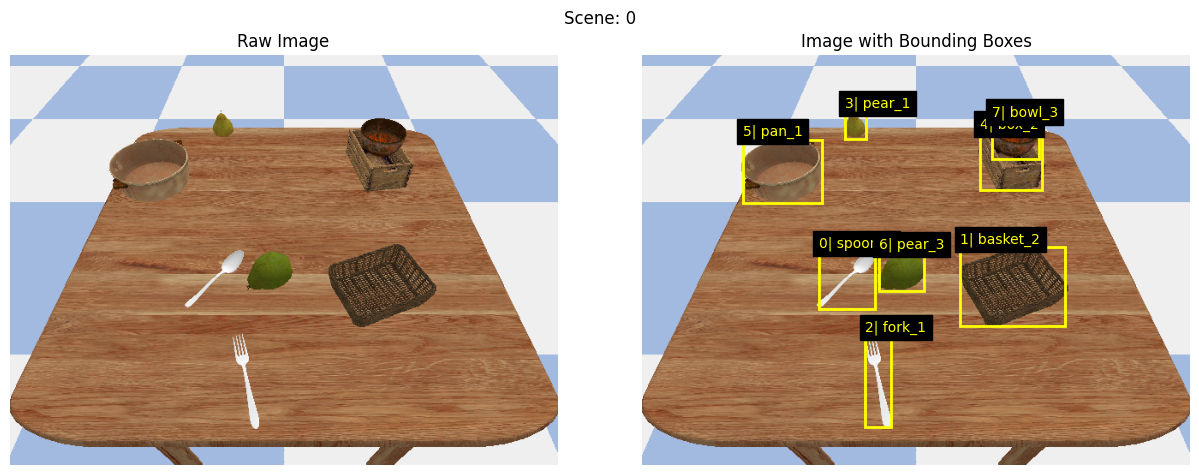

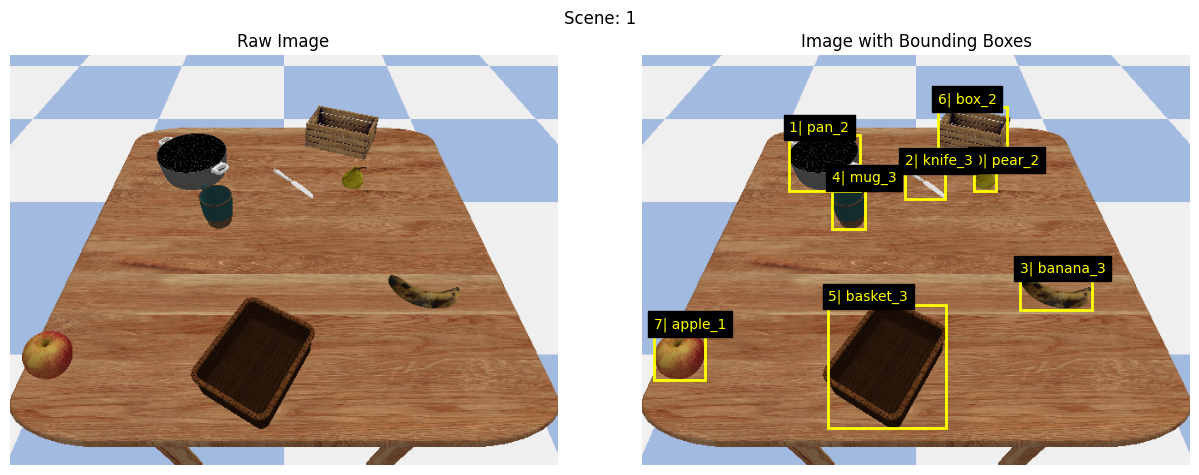

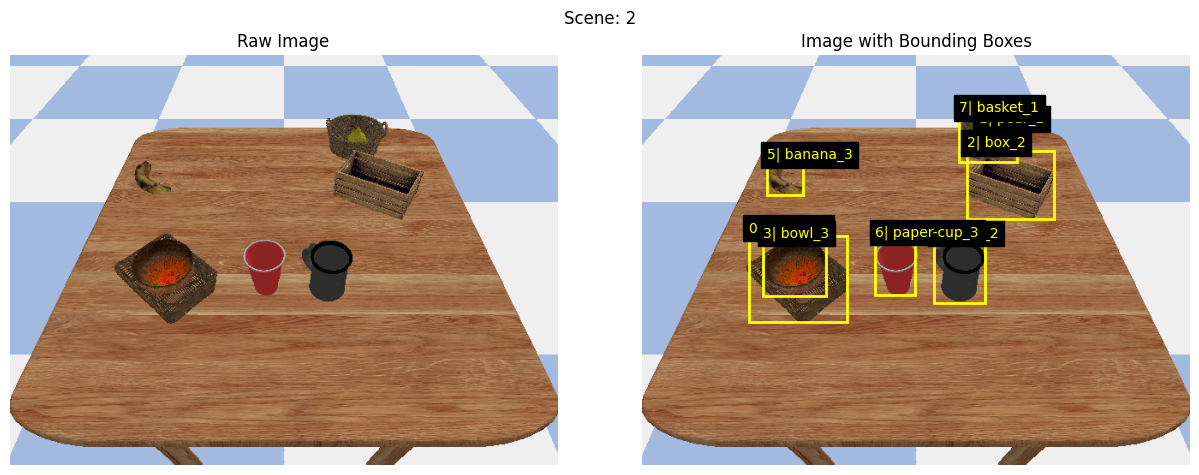

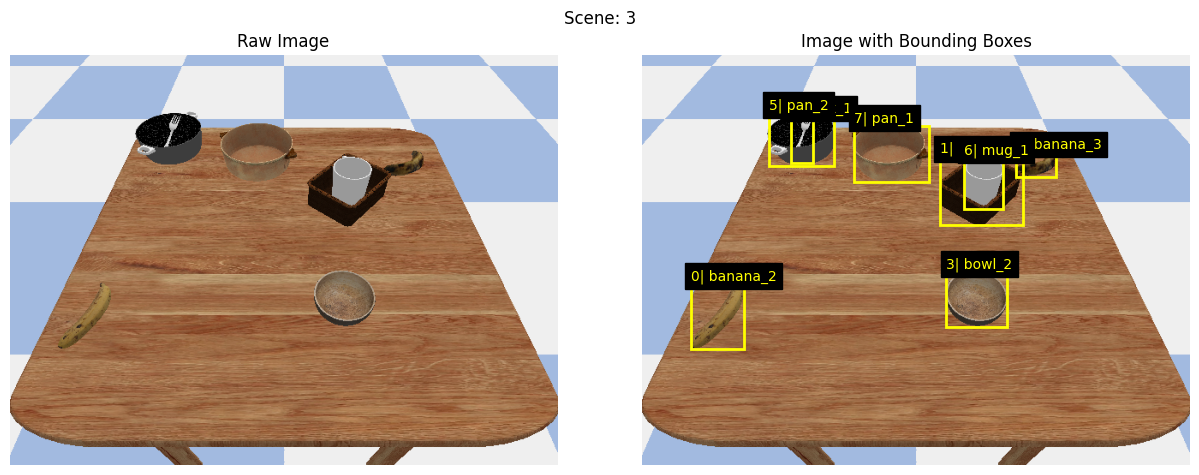

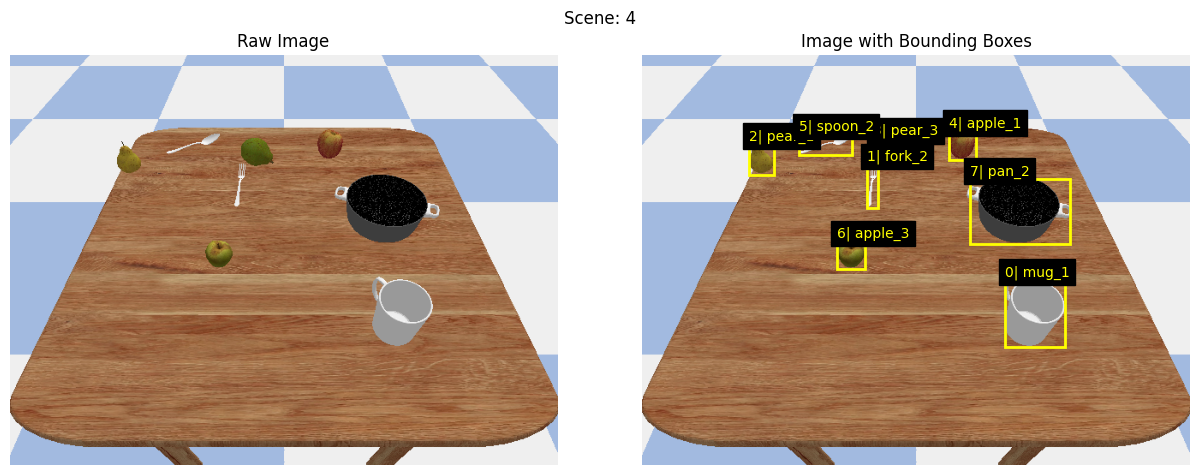

In [4]:
from collections import defaultdict, Counter

def get_available_body_types(objects, object_dir="objects"):
    available = {}
    for obj in objects:
        model_name = obj['model_name']
        if model_name not in available:
            available[model_name] = len(os.listdir(f"{object_dir}/{model_name}"))
    return available

def choose_least_used_body_type(model_name, available_body_types, counter):
    count = counter[model_name]
    num_types = available_body_types[model_name]
    min_used = min(count.get(bt, 0) for bt in range(1, num_types + 1))
    candidates = [bt for bt in range(1, num_types + 1) if count.get(bt, 0) == min_used]
    chosen = random.choice(candidates)
    counter[model_name][chosen] += 1
    return chosen

def compute_position_and_orientation(obj, objects, base_z):
    stack_hierarchy = 0
    j = obj['base_id']
    while j is not None:
        stack_hierarchy += 1
        j = objects[j]['base_id']

    pos = [obj['pos'][0], obj['pos'][1], base_z + 0.04 + 0.08 * stack_hierarchy]
    orn = [0, 0, 0]

    if stack_hierarchy > 0 and obj['label'] in [0, 1, 2]:
        orn[0] = np.pi / 2
        j = obj['base_id']
        if objects[j]['label'] in [6, 7]:
            pos, orn = random_tilt(pos, orn, max_shift=0.01, tilt_angle=10)
        elif objects[j]['label'] == 8:
            pos, orn = random_tilt(pos, orn, max_shift=0.02, shift_end=True, tilt_angle=20)
        else:
            orn[2] = random.uniform(0, 2 * np.pi)
    else:
        orn[2] = random.uniform(0, 2 * np.pi)

    return pos, orn

for scene_path in os.listdir("example_scenes"):
	# if scene_path != 'scene_1.json':
	# 	continue

	# sim = PyBulletSim(p.GUI)
	sim = PyBulletSim(p.DIRECT)
	table = load_table((100, 100))
	x, y, z = get_size(table)
	x_range, y_range = [-x/2, x/2], [-y/2, y/2]
	cam = Camera(target_pos=[0.55, 0, 1.3], distance=0.2, yaw=90, pitch=-50, roll=0)

	with open(os.path.join("example_scenes", scene_path)) as f:
		scene = json.load(f)

	# Preprocess
	objects = []
	for i, obj in enumerate(scene['objects']):
		label = int(obj['label'])
		model_name = OBJECTS[label]['name']
		objects.append({
			'object_id': i,
			'label': label,
			'model_name': model_name,
			'pos': map_position(obj['initial_pos'], x_range, y_range),
			'base_id': obj['initial_base_id'],
		})

	available_body_types = get_available_body_types(objects)
	body_type_counter = defaultdict(Counter)
     
	# Load each object
	for obj in objects:
		model_name = obj['model_name']
		pos, orn = compute_position_and_orientation(obj, objects, z)
		chosen_type = choose_least_used_body_type(model_name, available_body_types, body_type_counter)
		body_id, _ = load_object(model_name, pos, orn, bodyType=chosen_type)

		obj['body_id'] = body_id
		obj['body_type'] = chosen_type

	sim.step(5)

	json_data = []
	bboxes, labels = [], []
	for obj in objects:
		bbox = cam.compute_bounding_box(obj['body_id'], obj['model_name'], obj['body_type'])
		bboxes.append(bbox)
		labels.append(f"{obj['object_id']}| {obj['model_name']}_{obj['body_type']}")
		pos, orn = p.getBasePositionAndOrientation(obj['body_id'])
		euler = p.getEulerFromQuaternion(orn)
		json_data.append({
			"model_name": obj['model_name'],
			"model_id": f"{obj['model_name']}_{obj['body_type']}",
			"obj_id": obj['object_id'],
			"6D_pose": list(pos + euler),
			"natural_parent_list": [obj['base_id']] if obj['base_id'] is not None else [],
			"bbox": list(bbox),
		})

	cam.draw_bounding_boxes(cam.capture_image(), bboxes, labels, title=f'Scene: {scene["scene_id"]}')

	sim.close()
